# Modules

In [1]:
%load_ext autoreload
%autoreload 2w

In [2]:
import sys
import gc

import urllib.request
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, StrMethodFormatter
import matplotlib
import seaborn as sns
import cv2

import torch
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, ASGD, SGD
from sklearn.metrics import confusion_matrix

from IPython.display import display, HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

sys.path.append('..')
from src import config, dataset, models, utils

plt.rcParams.update(plt.rcParamsDefault)
plt.style.use(['ggplot', 'bmh'])
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

display_settings = {
    'max_columns': 999,
    'expand_frame_repr': True,
    'max_rows': 999,
    'precision': 4,
    'show_dimensions': True
}

for op, value in display_settings.items():
    pd.set_option("display.{}".format(op), value)


%matplotlib inline

In [3]:
def fix_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
fix_seeds()

# Data

In [4]:
label_cols = ['healthy', 'multiple_diseases', 'rust', 'scab']

df_train = pd.read_csv(config.METADATA_TRAIN)
df_test = pd.read_csv(config.METADATA_TEST)

# artificially augment the dataset by duplicating images. Randomized transforms are applied to each one to make then unique to the model
df_train = dataset.oversample(df_train, label_cols, factor=3)

df_train, df_val = dataset.stratified_split(df_train, label_cols)

ds_train = dataset.PlantPathology(df_train, label_cols=label_cols, is_test=False)
ds_val = dataset.PlantPathology(df_val, label_cols=label_cols, is_test=False)
ds_test = dataset.PlantPathology(df_test, is_test=True)

print(f'Number of images in training set: {len(ds_train)}')
print(f'Number of images in valiadtion set: {len(ds_val)}')
print(f'Number of images in test set: {len(ds_test)}')

Number of images in training set: 7137
Number of images in valiadtion set: 1785
Number of images in test set: 1821


## Target distribution

Images are partitioned into 4 distinct classes:
* leaves showing rust symptoms characterized by reddish circular spots. It's the most common occurrence in the dataset with 34% of the samples,
* leaves with scab disease characterized by brown spots and deformed leaves. It's the second most common class in the dataset where it appears on 33% of the samples,
* healthy leaves with no sign of a disease, accounting for 28% of the samples in the dataset,
* leaves with multiple diseases. This class is particular because it occurs when leaves show two or more diseases and as such can be viewed as a mixture of the rust and scab classes. However, such occurrences seem anecdotal as they represent around 5% of the samples. 

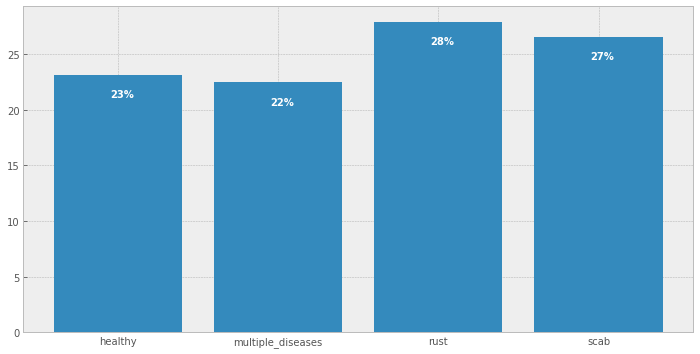

In [5]:
n_classes = len(ds_train.label_cols)
fig, ax = plt.subplots(figsize=(12, 6))

heights = [100 * ds_train.df_metadata[c].sum() / len(ds_train) for c in ds_train.label_cols]
ax.bar(x=ds_train.label_cols, height=heights)

for i, v in enumerate(heights):
    ax.text(i - .05, v - 2, f'{v:.0f}%', color='white', fontweight='bold')

## Training set images

Some observations:
* images don't have unit aspect ratio. They are of resolution 1365 x 2018 --> might reduce the resolution to speedup training,
* images have 3 channels (RGB), --> 3d grouped convolutions,
* leaves are almost always centered on images --> easier cropping,
* images often contain several leaves, either of the same tree or of different trees,
* images depth of field is low so that only the front leave is clear and the background is very blurry. However it happens that parts of the main leave is out of focus. --> Segmentation step to isolate main leave will likely improve model's performance,
* images are taken in nature, so lightning across images is different (direction, luminosity, color of the light source, direct or indirect lightning, reflections, shadows) --> might need histogram normalization

The images shown bellow are a comparison between the original samples and their transformed counterpart.

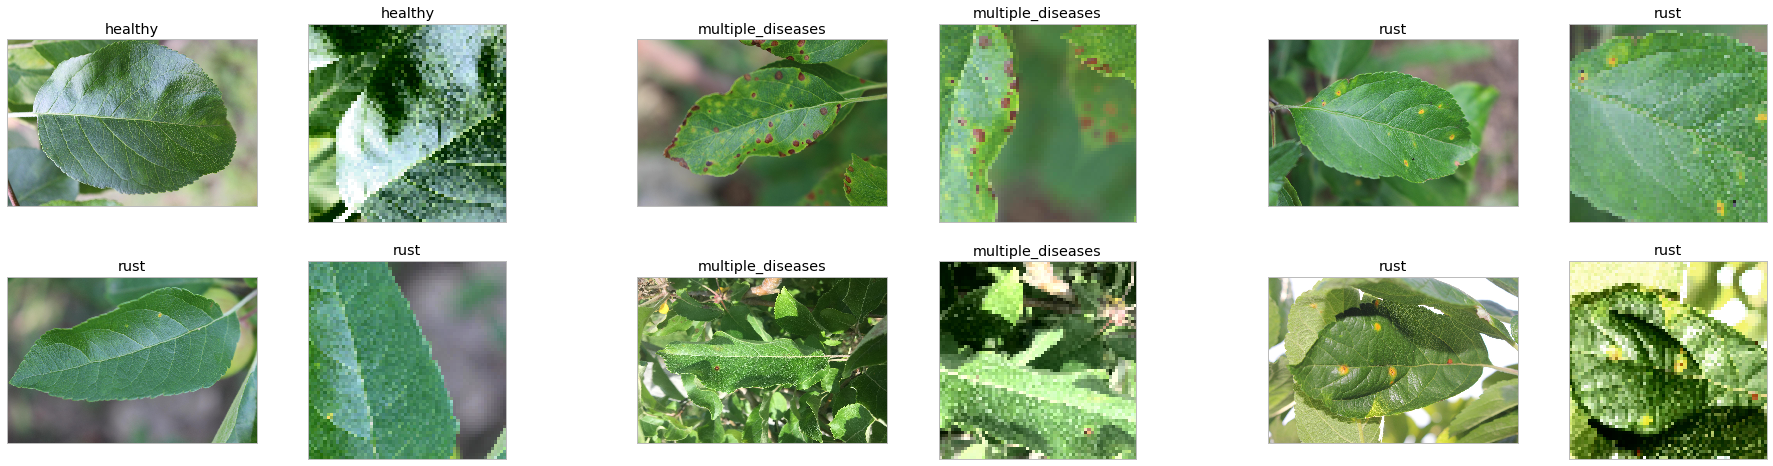

In [6]:
fig = utils.plot_samples(ds_train)

## Test set images

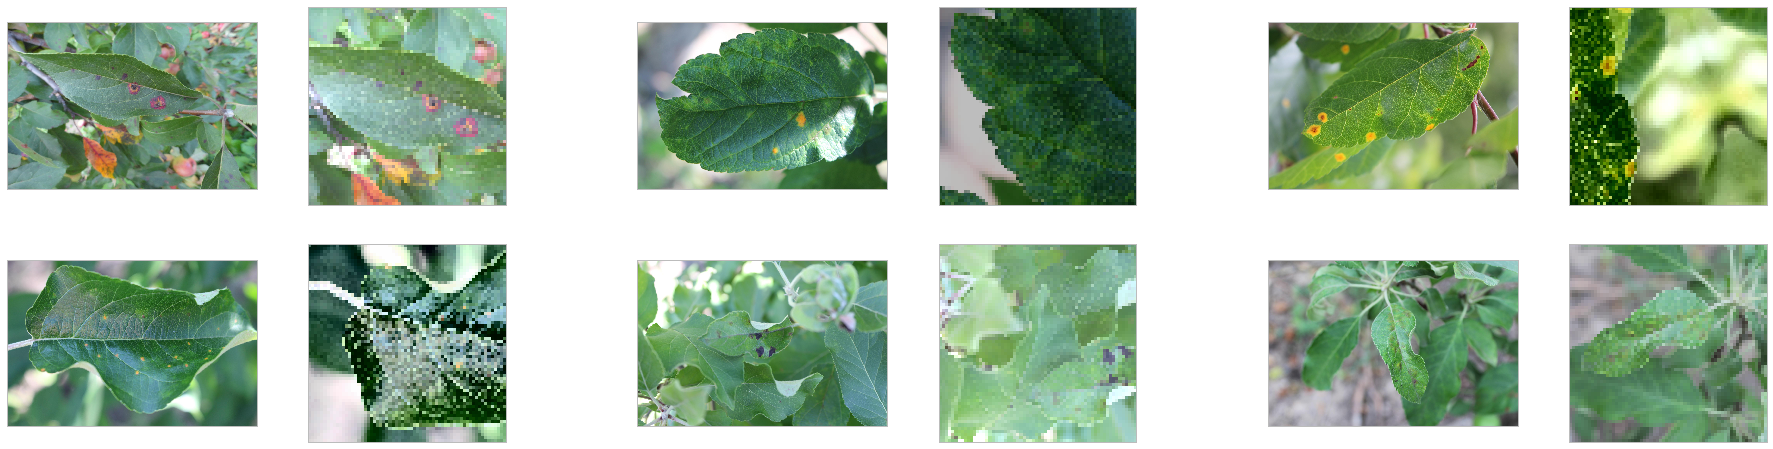

In [7]:
fig = utils.plot_samples(ds_test)

# Model

## Training

In [ ]:
def train(model, criterion, optimizer, dl_train, dl_val, n_epoch, restart_epoch, min_epoch=10, patience=5):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    loss_history = []
    eval_loss_history = []
    eval_roc_auc_history = []
    best_eval_roc_auc = 0
    trials = 0
    
    for epoch in range(restart_epoch, n_epochs + 1):
        # perform a full pass on the dataset
        model.train()
        epoch_loss = 0

        for i, batch in enumerate(dl_train):
            X, y = [ds.to(device) for ds in batch]

            # erase gradients and perform a forward pass
            optimizer.zero_grad()
            y_hat = model(X)
            # compute loss and perform a backward pass
            loss = criterion(y_hat, torch.argmax(y, dim=1))

            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

            del X, y
            torch.cuda.empty_cache()

        epoch_loss /= len(ds_train)
        loss_history.append(epoch_loss)
        
    # evaluate
    eval_loss, eval_roc_aux, _, _ = evaluate(model, criterion, optimizer, dl_val)
    eval_loss_history.append(eval_loss)
    eval_roc_auc_history.append(eval_roc_auc)
    
    if epoch % verbose == 0:
            print(f'Epoch: {epoch:3d} - Train loss: {epoch_loss:.4f} | Eval loss: {eval_loss:.4f} - Eval ROC-AUC: {eval_roc_auc:.4f}')

        if epoch > min_epoch:
            if eval_roc_auc > best_eval_roc_auc:
                trials = 0
                best_eval_roc_auc = eval_roc_auc

                del y_val_hat_running, y_val_running
                torch.cuda.empty_cache()

                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                }, config.get_model_filename('best'))

            else:
                trials += 1
                if trials >= patience:
                    print(f'Early stopping on epoch {epoch}')
                    break
    
    return loss_history, eval_loss_history, eval_roc_auc_history


def evaluate(model, criterion, optimizer, dl_val):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.eval()
    eval_loss = 0
    
    with torch.no_grad():
        y_val_hat_running = torch.tensor([], device=device)
        y_val_running = torch.tensor([], dtype=torch.long, device=device)
        
        for batch in dl_val:
            X, y = [ds.to(device) for ds in batch]
            y_hat = model(X)

            loss = criterion(y_hat, torch.argmax(y, dim=1))
            eval_loss += loss.item()
            
            y_hat = torch.log_softmax(y_hat, dim=1)
            
            y_val_hat_running = torch.cat([y_val_hat_running, y_hat], 0)
            y_val_running = torch.cat([y_val_running, y], 0)

            del X, y
            torch.cuda.empty_cache()
    
    eval_loss /= len(ds_val)
    eval_roc_auc = utils.mean_column_wise_roc_auc(y_val_hat_running.cpu().numpy(), y_val_running.cpu().numpy())
    
    return eval_loss, eval_roc_auc, y_hat_running, y_val_running


def predict(model, dl_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.eval()
    y_hat_running = torch.tensor([], device=device)
    
    with torch.no_grad():
        for batch in dl_test:
            X = [ds.to(device) for ds in batch]
            y_hat = model(X)            
            y_hat = torch.log_softmax(y_hat, dim=1)
            y_hat_running = torch.cat([y_val_hat_running, y_hat], 0)
            
            del X
            torch.cuda.empty_cache()
    
    return y_hat_running.cpu().numpy()

In [11]:
load_model = True

# hyperparameters
batch_size = 64
n_epochs = 100
learning_rate = 1e-3
min_epoch, patience = 10, 5
verbose = 1

# data loaders
dl_train = DataLoader(ds_train, batch_size, num_workers=0)
dl_val = DataLoader(ds_val, batch_size, num_workers=0)
dl_test = DataLoader(ds_test, batch_size, num_workers=0)
class_weigths = torch.tensor(ds_train.label_weights, device=device)

# model
model = models.WideResNet(in_channels=3, first_out_channels=8, n_classes=4, k=1, n=3).to(device)
#model.apply(models.weight_init)
criterion = CrossEntropyLoss(reduction='sum')
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)

if load_model:
    checkpoint = torch.load(config.get_model_filename('best'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    restart_epoch = checkpoint['epoch']
else:
    restart_epoch = 1
    
loss_history, eval_loss_history, eval_roc_auc_history = train(model, criterion, optimizer, dl_train, dl_val, n_epoch, restart_epoch, min_epoch, patience)

Epoch:  11 - Train loss: 0.9489 | Eval loss: 1.1974 - Eval ROC-AUC: 0.7833
Epoch:  12 - Train loss: 0.8668 | Eval loss: 1.0923 - Eval ROC-AUC: 0.8397
Epoch:  13 - Train loss: 0.8097 | Eval loss: 0.9530 - Eval ROC-AUC: 0.8604
Epoch:  14 - Train loss: 0.7574 | Eval loss: 1.3468 - Eval ROC-AUC: 0.8266
Epoch:  15 - Train loss: 0.7301 | Eval loss: 1.0361 - Eval ROC-AUC: 0.8768
Epoch:  16 - Train loss: 0.6943 | Eval loss: 1.6868 - Eval ROC-AUC: 0.8076
Epoch:  17 - Train loss: 0.6650 | Eval loss: 1.4749 - Eval ROC-AUC: 0.8415
Epoch:  18 - Train loss: 0.6630 | Eval loss: 1.1171 - Eval ROC-AUC: 0.8702
Epoch:  19 - Train loss: 0.6247 | Eval loss: 1.3843 - Eval ROC-AUC: 0.8524
Epoch:  20 - Train loss: 0.6145 | Eval loss: 1.5751 - Eval ROC-AUC: 0.8374
Early stopping on epoch 20


In [ ]:
fig, (ax_loss, ax_auc) = plt.subplots(ncols=2, figsize=(24, 8))

x = [i for i in range(len(eval_loss_history))]

ax_loss.plot(x, eval_loss_history, label='Evaluation')
ax_loss.plot(x, loss_history, label='Training')
ax_loss.set_xlabel('epoch')
ax_loss.set_ylabel('loss')
ax_loss.legend()

ax_auc.plot(x, eval_roc_auc_history)
ax_auc.set_xlabel('epoch')
ax_auc.set_ylabel('Macro ROC-AUC')

plt.show()

## Analysis of validation results

Confusion matrix $C = [c_{ij}]$ where $c_{ij}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$.

In [ ]:
_, _, y_val_hat_running, y_val_running = evaluate(model, criterion, optimizer, dl_val)

conf_mat = confusion_matrix(np.argmax(y_val_running.cpu().numpy(), axis=-1), 
                            np.argmax(y_val_hat_running.cpu().numpy(), axis=-1), 
                            normalize=None)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_mat, fmt='d', annot=True, cmap='YlGnBu', square=True, xticklabels=ds_val.label_cols, yticklabels=ds_val.label_cols)

## Inference

In [ ]:
y_hat = predict(model, dl_test)
df_predictions = pd.DataFrame(data=y_hat, columns=ds_test.label_cols, index=image_ids)

df_predictions.head()